In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw5.ipynb")

# CPSC 330 - Applied Machine Learning 

## Homework 5: Putting it all together 
### Associated lectures: All material till lecture 13 

**Due date: [Monday, Mar 10, 11:59 pm](https://github.com/UBC-CS/cpsc330-2024W2?tab=readme-ov-file#deliverable-due-dates-tentative)**

## Table of contents
0. [Submission instructions](#si)
1. [Understanding the problem](#1)
2. [Data splitting](#2)
3. [EDA](#3)
4. [Feature engineering](#4)
5. [Preprocessing and transformations](#5) 
6. [Baseline model](#6)
7. [Linear models](#7)
8. [Different models](#8)
9. [Feature selection](#9)
10. [Hyperparameter optimization](#10)
11. [Interpretation and feature importances](#11) 
12. [Results on the test set](#12)
13. [Summary of the results](#13)
14. [Your takeaway from the course](#15)

<div class="alert alert-info">

Test R² Score: 0.3263
## Submission instructions
<hr>
rubric={points:4}

**You may work with a partner on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).
- If you would like to use late tokens for the homework, all group members must have the necessary late tokens available. Please note that the late tokens will be counted for all members of the group.   


Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2024W2/blob/master/docs/homework_instructions.md). 

1. Before submitting the assignment, run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from "1" will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Follow the [CPSC 330 homework instructions](https://ubc-cs.github.io/cpsc330-2024W2/docs/homework_instructions.html), which include information on how to do your assignment and how to submit your assignment.
4. Upload your solution on Gradescope. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 
5. Make sure that the plots and output are rendered properly in your submitted file. If the .ipynb file is too big and doesn't render on Gradescope, also upload a pdf or html in addition to the .ipynb so that the TAs can view your submission on Gradescope.


_Note: The assignments will get gradually more open-ended as we progress through the course. In many cases, there won't be a single correct solution. Sometimes you will have to make your own choices and your own decisions (for example, on what parameter values to use when they are not explicitly provided in the instructions). Use your own judgment in such cases and justify your choices, if necessary._

</div>

<!-- BEGIN QUESTION -->

## Imports

<div class="alert alert-warning">
    
Imports
    
</div>

_Points:_ 0

In [2]:
import os
import sys
import time

sys.path.append(os.path.join(os.path.abspath(".."), "code"))
import seaborn as sns
import IPython
import matplotlib.pyplot as plt
import mglearn
import numpy as np
import pandas as pd
from IPython.display import HTML, display
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
# from plotting_functions import *
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
# from utils import *
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline
pd.set_option("display.max_colwidth", 200)
DATA_DIR = "../data/"

In [3]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores.iloc[i], std_scores.iloc[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

<!-- END QUESTION -->

## Introduction <a name="in"></a>

In this homework you will be working on an open-ended mini-project, where you will put all the different things you have learned so far together to solve an interesting problem.

A few notes and tips when you work on this mini-project: 

#### Tips
1. This mini-project is open-ended, and while working on it, there might be some situations where you'll have to use your own judgment and make your own decisions (as you would be doing when you work as a data scientist). Make sure you explain your decisions whenever necessary. 
2. **Do not include everything you ever tried in your submission** -- it's fine just to have your final code. That said, your code should be reproducible and well-documented. For example, if you chose your hyperparameters based on some hyperparameter optimization experiment, you should leave in the code for that experiment so that someone else could re-run it and obtain the same hyperparameters, rather than mysteriously just setting the hyperparameters to some (carefully chosen) values in your code. 
3. If you realize that you are repeating a lot of code try to organize it in functions. Clear presentation of your code, experiments, and results is the key to be successful in this lab. You may use code from lecture notes or previous lab solutions with appropriate attributions. 

#### Assessment
We plan to grade fairly and leniently. We don't have some secret target score that you need to achieve to get a good grade. **You'll be assessed on demonstration of mastery of course topics, clear presentation, and the quality of your analysis and results.** For example, if you just have a bunch of code and no text or figures, that's not good. If you do a bunch of sane things and get a lower accuracy than your friend, don't sweat it.


#### A final note
Finally, this style of this "project" question is different from other assignments. It'll be up to you to decide when you're "done" -- in fact, this is one of the hardest parts of real projects. But please don't spend WAY too much time on this... perhaps "a few hours" (15-20 hours???) is a good guideline for this project . Of course if you're having fun you're welcome to spend as much time as you want! But, if so, try not to do it out of perfectionism or getting the best possible grade. Do it because you're learning and enjoying it. Students from the past cohorts have found such kind of labs useful and fun and I hope you enjoy it as well. 

<br><br>

<!-- BEGIN QUESTION -->

## 1. Pick your problem and explain the prediction problem <a name="1"></a>
<hr>
rubric={points:3}

In this mini project, you have the option to choose on which dataset you will be working on. The tasks you will need to carry on will be similar, independently of your choice.

### Option 1
You can choose to work on a classification problem of predicting whether a credit card client will default or not. 
For this problem, you will use [Default of Credit Card Clients Dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset). In this data set, there are 30,000 examples and 24 features, and the goal is to estimate whether a person will default (fail to pay) their credit card bills; this column is labeled "default.payment.next.month" in the data. The rest of the columns can be used as features. You may take some ideas and compare your results with [the associated research paper](https://www.sciencedirect.com/science/article/pii/S0957417407006719), which is available through [the UBC library](https://www.library.ubc.ca/). 


### Option 2
You can choose to work on a regression problem using a [dataset](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data) of New York City Airbnb listings from 2019. As usual, you'll need to start by downloading the dataset, then you will try to predict `reviews_per_month`, as a proxy for the popularity of the listing. Airbnb could use this sort of model to predict how popular future listings might be before they are posted, perhaps to help guide hosts create more appealing listings. In reality they might instead use something like vacancy rate or average rating as their target, but we do not have that available here.

> Note there is an updated version of this dataset with more features available [here](http://insideairbnb.com/). The features were are using in `listings.csv.gz` for the New York city datasets. You will also see some other files like `reviews.csv.gz`. For your own interest you may want to explore the expanded dataset and try your analysis there. However, please submit your results on the dataset obtained from Kaggle.


**Your tasks:**

1. Spend some time understanding the options and pick the one you find more interesting (it may help spending some time looking at the documentation available on Kaggle for each dataset).
2. After making your choice, focus on understanding the problem and what each feature means, again using the documentation on the dataset page on Kaggle. Write a few sentences on your initial thoughts on the problem and the dataset. 
3. Download the dataset and read it as a pandas dataframe. 

<div class="alert alert-warning">
    
Solution_1
    
</div>

_Points:_ 3

Looking at the documentation, the names of the listing are interesting, as they all have descriptors within them, so count_vectorizing the names may be a useful feature to include. This problem is definitely a regression problem. We will need to drop the *number_of_reviews* column, as that could very obviously be data leakage from *reviews_per_month*. My initial thought is that reviews_per_month might not be the best metric for popularity, as there might be long-term renters (especially in NY).

In [4]:
airbnb = pd.read_csv("AB_NYC_2019.csv")
airbnb['name'] = airbnb['name'].fillna("")


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 2. Data splitting <a name="2"></a>
<hr>
rubric={points:2}

**Your tasks:**

1. Split the data into train (70%) and test (30%) portions with `random_state=123`.

> If your computer cannot handle training on 70% training data, make the test split bigger.  

<div class="alert alert-warning">
    
Solution_2
    
</div>

_Points:_ 2

In [5]:
train_df, test_df = train_test_split(airbnb, test_size = 0.9, random_state = 123, shuffle = True)

After waiting 45+ minutes for some models to run, (and until failure for cv), I approached Prof. Gulia about this issue. She advised me to shorten my train_size down to ~3k values.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 3. EDA <a name="3"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Perform exploratory data analysis on the train set.
2. Include at least two summary statistics and two visualizations that you find useful, and accompany each one with a sentence explaining it.
3. Summarize your initial observations about the data. 
4. Pick appropriate metric/metrics for assessment. 

<div class="alert alert-warning">
    
Solution_3
    
</div>

_Points:_ 10

In [6]:
train_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
8829,6768399,3)Cozy Sunny Warm Room 阳光温馨单房 停车容易,30616879,Anna,Queens,Flushing,40.75443,-73.80787,Private room,48,2,53,2019-04-07,1.07,3,153
9030,6930780,Beautiful Sunny Top Floor 1BD Flat,36333834,Paul,Brooklyn,Bedford-Stuyvesant,40.68378,-73.93573,Entire home/apt,139,4,152,2019-06-13,3.26,1,281
19652,15735169,Spacious studio in Upper East Side,85726670,Priscilla,Manhattan,Upper East Side,40.77043,-73.95557,Entire home/apt,150,3,2,2019-06-09,0.08,1,0
22344,18041862,Bushwick's Private Modern Space,124142417,Marlene,Brooklyn,Bushwick,40.68824,-73.91567,Entire home/apt,100,2,111,2019-06-18,4.12,2,10
25129,20135558,"Awesome Newly Renovated 2-bdrm. - E,F,J trains.",143186772,Femi,Queens,Jamaica,40.69499,-73.79910,Entire home/apt,130,2,95,2019-06-27,4.19,1,117


Above is the dataset, looking at it, we have 9 numerical variables, and 2 categorical. There are a few here that are similar for us currently (long., lat. & neighbourhood), and a few that need to be dropped to keep up with the golden rule (number_of_reviews).

In [7]:
print(train_df.isnull().sum())

id                                  0
name                                0
host_id                             0
host_name                           2
neighbourhood_group                 0
neighbourhood                       0
latitude                            0
longitude                           0
room_type                           0
price                               0
minimum_nights                      0
number_of_reviews                   0
last_review                       982
reviews_per_month                 982
calculated_host_listings_count      0
availability_365                    0
dtype: int64


last_review has around 25% of its info missing, which will need to be dealt with later. luckily number_of_reviews will be dropped. reviews_per_month is missing around 25% of its data. Since we are trying to predict it, all datapoints without that must be scrubbed. We should assume that this is throughout, and remove all of them from the entire dataset. 

In [8]:
print(train_df.describe())

                 id       host_id     latitude    longitude        price  \
count  4.889000e+03  4.889000e+03  4889.000000  4889.000000  4889.000000   
mean   1.872368e+07  6.572780e+07    40.729061   -73.951424   149.055021   
std    1.100551e+07  7.741428e+07     0.054971     0.046955   240.470116   
min    6.021000e+03  2.438000e+03    40.508730   -74.239140    15.000000   
25%    9.106735e+06  7.728754e+06    40.689620   -73.982560    69.000000   
50%    1.920989e+07  2.893732e+07    40.722220   -73.955100   105.000000   
75%    2.896169e+07  1.052395e+08    40.763800   -73.935660   175.000000   
max    3.648543e+07  2.738493e+08    40.912340   -73.721730  9999.000000   

       minimum_nights  number_of_reviews  reviews_per_month  \
count     4889.000000        4889.000000        3907.000000   
mean         6.649622          23.011659           1.318626   
std         17.394320          43.489897           1.611563   
min          1.000000           0.000000           0.010000   


In [9]:
print(airbnb['neighbourhood_group'].value_counts())
print(airbnb['room_type'].value_counts())

neighbourhood_group
Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: count, dtype: int64
room_type
Entire home/apt    25409
Private room       22326
Shared room         1160
Name: count, dtype: int64


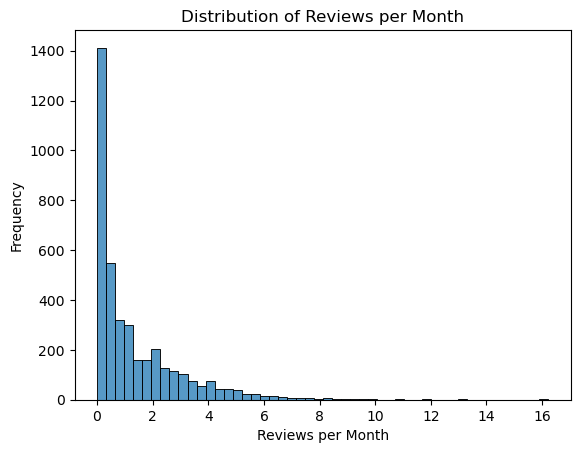

In [10]:
sns.histplot(train_df['reviews_per_month'], bins=50)
plt.title('Distribution of Reviews per Month')
plt.xlabel('Reviews per Month')
plt.ylabel('Frequency')
plt.show()

The distribution of reviews_per_month is heavily skewed towards 0 (direct result of long-tail economics), and thus, we will have very low values to analyze. 

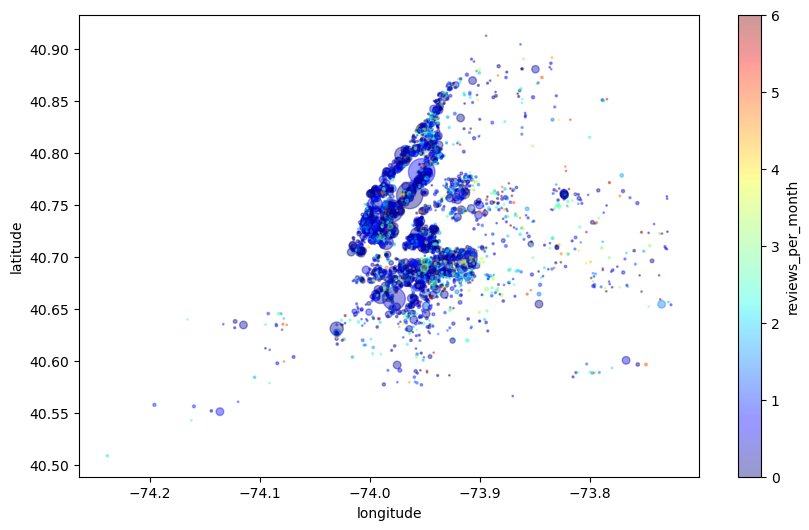

In [11]:
## (optional)
train_df.plot(
    kind="scatter",
    x="longitude",
    y="latitude",
    alpha=0.4,
    s=train_df["minimum_nights"],
    figsize=(10, 6),
    c="reviews_per_month",
    cmap=plt.get_cmap("jet"),
    colorbar=True,
    vmin = 0,
    vmax = 6,
    sharex=False,
);



While probably not going to be used, as we cannot work with coordinates yet in this class, I was born and raised in New York, and know the geography well. This gives me a good understanding of the regionality and a visual understanding of which neighbourhoods might be helpful. This [NYTimes](https://www.nytimes.com/interactive/2023/10/29/upshot/new-york-neighborhood-guide.html) article (albeit more sociological than necessary) is good insight to look at. Overall, it looks like Queens is more popular, and shows that the neighbourhood and neighbourhood_group features may be useful. It also shows that many long-term listings are in Manhattan, indicating that reviews_per_month might not even be that good of a Target to show popularity, as only one person/group might inhabit that airbnb for an extended period of time.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 4. Feature engineering <a name="4"></a>
<hr>
rubric={points:1}

**Your tasks:**

1. Carry out feature engineering. In other words, extract new features relevant for the problem and work with your new feature set in the following exercises. You may have to go back and forth between feature engineering and preprocessing. 

<div class="alert alert-warning">
    
Solution_4
    
</div>

_Points:_ 1

In [12]:
print(f"Number of rows before dropping missing target values: {len(train_df)}")
from sklearn.impute import SimpleImputer
# Drop missing target values
train_df = train_df.dropna(subset=['reviews_per_month'])
test_df = test_df.dropna(subset = ['reviews_per_month'])
X_train = train_df.drop(columns = ["reviews_per_month"])
y_train = train_df["reviews_per_month"].values
X_test = test_df.drop(columns = ["reviews_per_month"])
y_test = test_df["reviews_per_month"].values
print(f"Number of rows after dropping missing target values: {len(train_df)}")

Number of rows before dropping missing target values: 4889
Number of rows after dropping missing target values: 3907


We will remove host_name (as it is the same as Host ID, but with missing values), id (as it is useless and only to show uniqueness, long. lat. & last_review as we have not learned to handle it yet, and number_of_reviews as that breaks the Golden Rule. Since we are predicting reviews_per_month, we cannot do this on objects that are missing this value, and thus, the NaN values for this will be removed. Host ID would be a useful metric, however, the number of hosts that only represent one house can be assumed to be large. While this may be a slightly useful metric, the computing power and complexity that this feature would command justifies its removal

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 5. Preprocessing and transformations <a name="5"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Identify different feature types and the transformations you would apply on each feature type. 
2. Define a column transformer, if necessary. 

<div class="alert alert-warning">
    
Solution_5
    
</div>

_Points:_ 10

In [13]:
numeric_feats = ['price','minimum_nights','calculated_host_listings_count','availability_365']
categorical_feats = ['neighbourhood_group']
words = 'name'
drop_feats = ['host_name','host_id','latitude','longitude', 'id','last_review','neighbourhood','number_of_reviews']

ordinal_feats = ['room_type']
room_levels = ['Entire home/apt', 'Private room', 'Shared room']

In [14]:
from sklearn.compose import make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder 



ct = make_column_transformer(
    (
        make_pipeline(SimpleImputer(), StandardScaler()),
        numeric_feats,
    ),  # scaling on numeric features
    (
        OneHotEncoder(drop="if_binary", dtype=int,handle_unknown="ignore"),
        categorical_feats,
    ),  # OHE on categorical features
    (
        OrdinalEncoder(categories=[room_levels], dtype=int),
        ordinal_feats,
    ),  # Ordinal encoding on ordinal features
    (
        CountVectorizer(max_features=100, stop_words = 'english'),
        words,
    ),  # CV on categorical features
    ("drop", drop_feats),  # drop the drop features
)


In [15]:
ct

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['price', 'minimum_nights',
                                  'calculated_host_listings_count',
                                  'availability_365']),
                                ('onehotencoder',
                                 OneHotEncoder(drop='if_binary',
                                               dtype=<class 'int'>,
                                               handle_unknown='ignore'),
                                 ['neighbourhood_group']),
                                ('ordinalencoder',
                                 OrdinalEncoder(categories=[['Entire home/apt',
                                                             'Private room',
                                                             'Shared room']],
                                                dtype=<class 'int'>),
                                 ['room_type']),
                                ('countvectorizer',
                                 CountVectorizer(max_features=100,
                                                 stop_words='english'),
                                 'name'),
                                ('drop', 'drop',
                                 ['host_name', 'host_id', 'latitude',
                                  'longitude', 'id', 'last_review',
                                  'neighbourhood', 'number_of_reviews'])])

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 6. Baseline model <a name="6"></a>
<hr>
rubric={points:2}

**Your tasks:**
1. Try `scikit-learn`'s baseline model and report results.

<div class="alert alert-warning">
    
Solution_6
    
</div>

_Points:_ 2

In [16]:
from sklearn.dummy import DummyRegressor
scores = {}
pipe_dum = make_pipeline(ct, DummyRegressor())
scores["Dummy"] = mean_std_cross_val_scores(pipe_dum, X_train, y_train, return_train_score=True)
pd.DataFrame(scores).T

,fit_time,score_time,test_score,train_score
Dummy,0.083 (+/- 0.020),0.023 (+/- 0.001),-0.001 (+/- 0.001),0.000 (+/- 0.000)


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 7. Linear models <a name="7"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Try a linear model as a first real attempt. 
2. Carry out hyperparameter tuning to explore different values for the complexity hyperparameter. 
3. Report cross-validation scores along with standard deviation. 
4. Summarize your results.

<div class="alert alert-warning">
    
Solution_7
    
</div>

_Points:_ 10

So far the model is not performing amazing. Scoring 0.091 with a SD of 0.025 indicates that it is only slightly better than the Dummy model.

In [17]:
from sklearn.svm import SVC
from sklearn.linear_model import Ridge

pipe = make_pipeline(ct, Ridge())

In [18]:
param_grid = {"ridge__alpha": 10.0 ** np.arange(-5, 5, 1)}
search = GridSearchCV(pipe, param_grid, return_train_score=True, n_jobs=-1)
search.fit(X_train, y_train)
train_scores = search.cv_results_["mean_train_score"]
cv_scores = search.cv_results_["mean_test_score"]
#code taken from Lecture 10

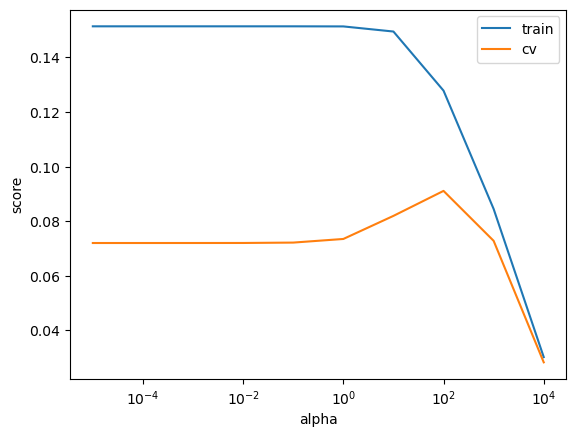

In [19]:
plt.semilogx(param_grid["ridge__alpha"], train_scores.tolist(), label="train")
plt.semilogx(param_grid["ridge__alpha"], cv_scores.tolist(), label="cv")
plt.legend()
plt.xlabel("alpha")
plt.ylabel("score");

In [20]:
best_alpha = search.best_params_["ridge__alpha"]
best_alpha

np.float64(100.0)

In [21]:
pipe_r = make_pipeline(ct, Ridge(alpha = best_alpha))
scores["Ridge"] = mean_std_cross_val_scores(pipe_r, X_train, y_train, return_train_score=True)
pd.DataFrame(scores).T

,fit_time,score_time,test_score,train_score
Dummy,0.083 (+/- 0.020),0.023 (+/- 0.001),-0.001 (+/- 0.001),0.000 (+/- 0.000)
Ridge,0.082 (+/- 0.005),0.025 (+/- 0.001),0.091 (+/- 0.025),0.128 (+/- 0.009)


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 8. Different models <a name="8"></a>
<hr>
rubric={points:12}

**Your tasks:**
1. Try at least 3 other models aside from a linear model. One of these models should be a tree-based ensemble model. 
2. Summarize your results in terms of overfitting/underfitting and fit and score times. Can you beat a linear model? 

<div class="alert alert-warning">
    
Solution_8
    
</div>

_Points:_ 12

XGboost performs the best out of all these models. Random Forest is incredibly overfitted, as it goes as deep as needed; however, that doesn't (and shouldn't) impact test scoring. SVR rbf has the largest % $\Delta$ from train to test of a model not designed to overfit with 100%.

In [22]:
from sklearn.ensemble import RandomForestRegressor

pipe_dt = make_pipeline(ct, RandomForestRegressor(random_state=123,n_jobs = -1))
scores["Random Forest"] = mean_std_cross_val_scores(
    pipe_dt, X_train, y_train, return_train_score=True,
)

In [23]:
from sklearn.svm import SVR
pipe_lr = make_pipeline(ct, SVR(kernel="rbf"))
scores["SVR RBF"] = mean_std_cross_val_scores(
    pipe_lr, X_train, y_train, return_train_score=True,
)

In [24]:
from sklearn.linear_model import LinearRegression

pipe_lasso = make_pipeline(ct, LinearRegression())
scores["Lasso"] = mean_std_cross_val_scores(
    pipe_lasso, X_train, y_train, return_train_score=True,
)

In [25]:
from xgboost import XGBRegressor 


pipe_xgb = make_pipeline(ct, XGBRegressor(random_state=123))
scores["XGBoost"] = mean_std_cross_val_scores(
    pipe_xgb, X_train, y_train, return_train_score=True,
)
pd.DataFrame(scores).T

,fit_time,score_time,test_score,train_score
Dummy,0.083 (+/- 0.020),0.023 (+/- 0.001),-0.001 (+/- 0.001),0.000 (+/- 0.000)
Ridge,0.082 (+/- 0.005),0.025 (+/- 0.001),0.091 (+/- 0.025),0.128 (+/- 0.009)
Random Forest,4.099 (+/- 0.152),0.112 (+/- 0.008),0.276 (+/- 0.022),0.899 (+/- 0.003)
SVR RBF,1.499 (+/- 0.041),0.302 (+/- 0.014),0.144 (+/- 0.011),0.287 (+/- 0.013)
Lasso,0.092 (+/- 0.005),0.040 (+/- 0.033),0.072 (+/- 0.036),0.151 (+/- 0.010)
XGBoost,0.755 (+/- 0.759),0.031 (+/- 0.007),0.247 (+/- 0.055),0.864 (+/- 0.005)


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 9. Feature selection <a name="9"></a>
<hr>
rubric={points:2}

**Your tasks:**

Make some attempts to select relevant features. You may try `RFECV` or forward selection for this. Do the results improve with feature selection? Summarize your results. If you see improvements in the results, keep feature selection in your pipeline. If not, you may abandon it in the next exercises. 

<div class="alert alert-warning">
    
Solution_9
    
</div>

_Points:_ 2

Feature selection does improve the results and performance, almost halving the number of features.

In [26]:
from sklearn.feature_selection import RFECV


ct.fit(X_train, y_train);


# Extract OneHotEncoder feature names correctly
ohe_feature_names = (
    ct.named_transformers_["onehotencoder"].get_feature_names_out(categorical_feats).tolist()
)

# Extract CountVectorizer feature names correctly
cv_feature_names = (
    ct.named_transformers_["countvectorizer"].get_feature_names_out().tolist()
)

# Combine all feature names
feature_names = numeric_feats + ordinal_feats + ohe_feature_names + cv_feature_names


X_train_enc = pd.DataFrame(
    data=ct.transform(X_train).toarray(),
    columns=feature_names,
    index=X_train.index,
)
X_test_enc = pd.DataFrame(
    data=ct.transform(X_test).toarray(),
    columns=feature_names,
    index=X_test.index,
)


rfe_cv = RFECV(
    estimator= RandomForestRegressor(n_estimators=5,random_state=123,n_jobs = -1),
    cv=10,
    step=1,
    scoring="neg_mean_squared_error",  # For regression tasks
    n_jobs=-1  # Uses all available processors
)

# Fit RFECV
rfe_cv.fit(X_train_enc, y_train)

# Print selected features
selected_features = X_train_enc.columns[rfe_cv.support_]
print(f"Optimal number of features: {rfe_cv.n_features_}")
# 
# print("Selected Features:", selected_features.tolist())

Optimal number of features: 58


In [27]:
X_train_selected = X_train_enc.loc[:, selected_features]
X_test_selected = X_test_enc.loc[:,selected_features]

In [28]:
print("Shape of optimized dataset: " + str(X_train_selected.shape))
print("Shape of original dataset: " + str( X_train_enc.shape))


Shape of optimized dataset: (3907, 58)
Shape of original dataset: (3907, 110)


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 10. Hyperparameter optimization <a name="10"></a>
<hr>
rubric={points:10}

**Your tasks:**

Make some attempts to optimize hyperparameters for the models you've tried and summarize your results. In at least one case you should be optimizing multiple hyperparameters for a single model. You may use `sklearn`'s methods for hyperparameter optimization or fancier Bayesian optimization methods. 
  - [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)   
  - [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
  - [scikit-optimize](https://github.com/scikit-optimize/scikit-optimize) 

<div class="alert alert-warning">
    
Solution_10
    
</div>

_Points:_ 10

While this may be an issue of a low training size, out of the three optimized models, only XGBoost's cv testing scores increased. However, as this is our most accurate model, this optimization currently is the most important.

In [29]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [50, 100, 200, 300, 500],  # Number of boosting rounds
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],  # Step size
    'max_depth': [3, 5, 7, 10],  # Depth of each tree
    'subsample': [0.5, 0.7, 1.0],  # Fraction of samples per tree
    'colsample_bytree': [0.5, 0.7, 1.0],  # Fraction of features per tree
    'reg_lambda': [0, 1, 5, 10],  # L2 regularization
    'reg_alpha': [0, 1, 5, 10]  # L1 regularization
}




random_search = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=123),
    param_distributions=param_dist,
    n_iter=20,  # Reduce for speed, increase for better tuning
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',
    n_jobs=-1,  # Use all CPU cores
    # verbose=2,  # Show progress
    random_state=123
)

In [30]:
random_search.fit(X_train_selected, y_train)

# Best parameters
print("Best Parameters:", random_search.best_params_)

Best Parameters: {'subsample': 0.5, 'reg_lambda': 5, 'reg_alpha': 5, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


In [31]:

best_xgb = XGBRegressor(**random_search.best_params_, random_state=123)
best_xgb.fit(X_train_selected, y_train)

scores["XGBoost optimized"] = mean_std_cross_val_scores(
    best_xgb, X_train_selected, y_train, return_train_score=True,
)

In [32]:
param_dist = {
    'alpha': np.logspace(-3, 3, 50)  # Try values from 0.001 to 1000
}

random_search = RandomizedSearchCV(
    estimator=Ridge(random_state=123),
    param_distributions=param_dist,
    n_iter=20,  
    cv=5, 
    scoring='neg_mean_squared_error',  # Minimize MSE
    n_jobs=-1, 
    verbose=2,  # Show progress
    random_state=123
)
random_search.fit(X_train_selected, y_train)
print("Best alpha:", random_search.best_params_['alpha'])
best_ridge = Ridge(**random_search.best_params_, random_state=123)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best alpha: 79.06043210907701


In [33]:
best_ridge.fit(X_train_selected, y_train)

scores["Ridge optimized"] = mean_std_cross_val_scores(
    best_ridge, X_train_selected, y_train, return_train_score=True,
)

In [34]:
param_dist = {
    'C': np.logspace(-3, 3, 50), 
    'gamma': np.logspace(-4, 2, 50), 
    'epsilon': np.linspace(0.01, 1, 50)  
}

svr = SVR(kernel='rbf')

random_search = RandomizedSearchCV(
    estimator=svr,
    param_distributions=param_dist,
    n_iter=20, 
    cv=5, 
    scoring='neg_mean_squared_error',  # Minimize MSE
    n_jobs=-1, 
    # verbose=2,  # Show progress
    random_state=123
)
random_search.fit(X_train_selected, y_train)
best_svr = SVR(**random_search.best_params_, kernel = 'rbf')


In [35]:
best_svr.fit(X_train_selected, y_train)

scores["SVR RBF optimized"] = mean_std_cross_val_scores(
    best_svr, X_train_selected, y_train, return_train_score=True,
)

In [36]:
pd.DataFrame(scores).T

,fit_time,score_time,test_score,train_score
Dummy,0.083 (+/- 0.020),0.023 (+/- 0.001),-0.001 (+/- 0.001),0.000 (+/- 0.000)
Ridge,0.082 (+/- 0.005),0.025 (+/- 0.001),0.091 (+/- 0.025),0.128 (+/- 0.009)
Random Forest,4.099 (+/- 0.152),0.112 (+/- 0.008),0.276 (+/- 0.022),0.899 (+/- 0.003)
SVR RBF,1.499 (+/- 0.041),0.302 (+/- 0.014),0.144 (+/- 0.011),0.287 (+/- 0.013)
Lasso,0.092 (+/- 0.005),0.040 (+/- 0.033),0.072 (+/- 0.036),0.151 (+/- 0.010)
XGBoost,0.755 (+/- 0.759),0.031 (+/- 0.007),0.247 (+/- 0.055),0.864 (+/- 0.005)
XGBoost optimized,0.634 (+/- 0.177),0.031 (+/- 0.007),0.314 (+/- 0.034),0.467 (+/- 0.011)
Ridge optimized,0.023 (+/- 0.016),0.006 (+/- 0.001),0.084 (+/- 0.025),0.116 (+/- 0.010)
SVR RBF optimized,0.713 (+/- 0.165),0.189 (+/- 0.021),0.125 (+/- 0.014),0.154 (+/- 0.008)


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 11. Interpretation and feature importances <a name="1"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Use the methods we saw in class (e.g., `shap`) (or any other methods of your choice) to examine the most important features of one of the non-linear models. 
2. Summarize your observations. 

<div class="alert alert-warning">
    
Solution_11
    
</div>

_Points:_ 10

``availability_365`` technically is data leakage, breaking the Golden Rule, as reviews_per_month shares a portion of the units with availability; however, for this case, keeping it in isn't the worst, as it is also a good predictor of how many people are able to book. As such, it is the most important feature, with less availability correlated with a lower reviews_per_month. `minimum_nights` also follows this problem, as it partially representative of time; however, this is an important look into how our Target is skewed by information other than 'popularity'. It is *impossible* to have a high `reviews_per_month` score, even if the airbnb is booked 365 days out of the year, if the `minimum_nights` is high. If there is a 100 year waitlist, but one needs to book the airbnb for a year, then the `reviews_per_month` could sit at a maximum size of 0.083. Interestingly, `price` is a limiting factor, and a great indicator of `reviews_per_month`.

In [37]:
import shap 
model  = best_xgb.fit(X_train_selected,y_train)
explainer = shap.TreeExplainer(model) # define the shap explainer 
train_shap_values = explainer(X_train_selected) # train shap values


In [38]:
shap.initjs()

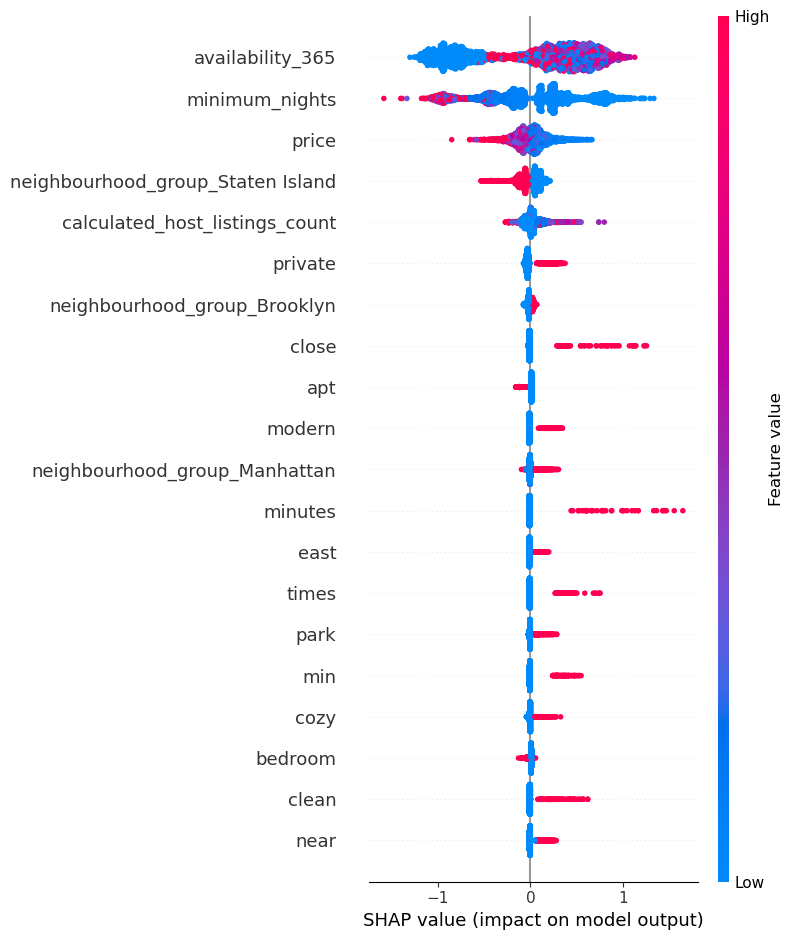

In [39]:
shap.summary_plot(train_shap_values, X_train_selected)

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 12. Results on the test set <a name="12"></a>
<hr>

rubric={points:10}

**Your tasks:**

1. Try your best performing model on the test data and report test scores. 
2. Do the test scores agree with the validation scores from before? To what extent do you trust your results? Do you think you've had issues with optimization bias? 
3. Take one or two test predictions and explain these individual predictions (e.g., with SHAP force plots).  

<div class="alert alert-warning">
    
Solution_12
    
</div>

_Points:_ 10

The optimized XGBoost scored better on the test_set then the cross-validation. I trust these results, and don't think that a tree-based ensemble model will have optimization bias as it holds a host of models within. As well, scoring better on an incredibly large test set minimizes the risk of chance scores by removing variability. 

In [40]:
test_res = best_xgb.score(X_test_selected, y_test)
print(f"Test R² Score: {test_res:.4f}")


Test R² Score: 0.3263


In [41]:
sample_index = [0, 1]  # Choose the first two test samples
X_sample = X_test_selected.iloc[sample_index]
shap_values = explainer(X_sample)

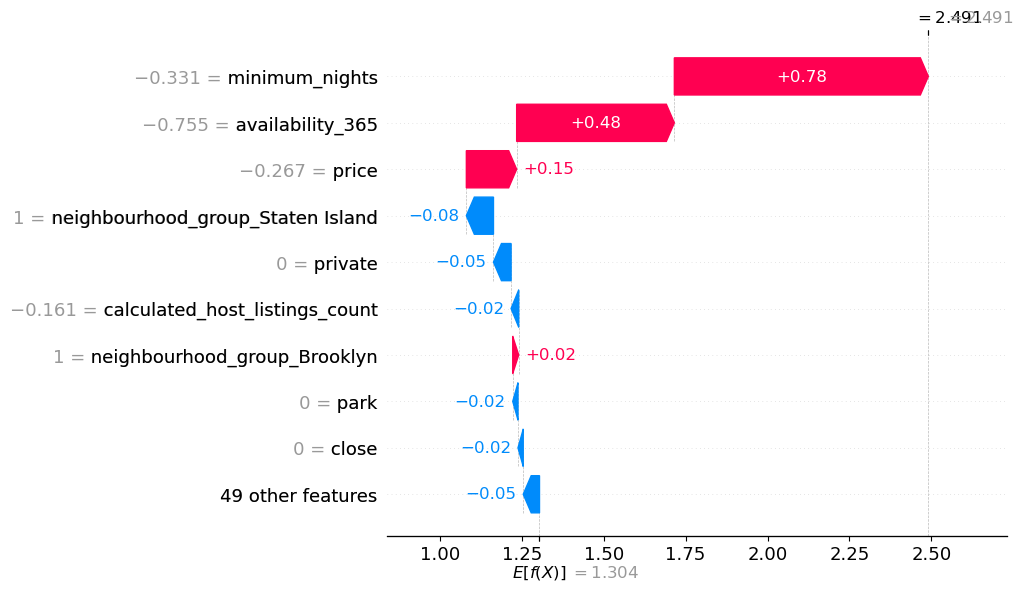

In [42]:
shap.plots.waterfall(shap_values[0])  # First test sampleplt.show()

For both of these plots, one can see that `availability` and `minimum_nights` are the most significant features by far. Again, it can be argued that both of these features break the Golden Rule.

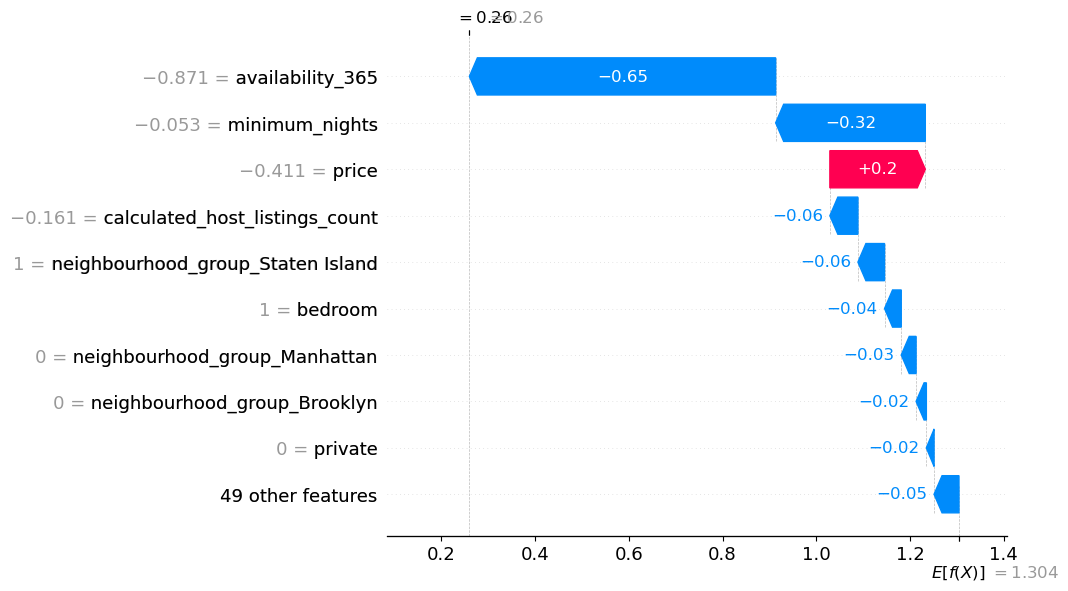

In [43]:
shap.plots.waterfall(shap_values[1])  # First test sampleplt.show()plt.show()

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 13. Summary of results <a name="13"></a>
<hr>
rubric={points:12}

Imagine that you want to present the summary of these results to your boss and co-workers. 

**Your tasks:**

1. Create a table summarizing important results. 
2. Write concluding remarks.
3. Discuss other ideas that you did not try but could potentially improve the performance/interpretability . 
3. Report your final test score along with the metric you used at the top of this notebook in the [Submission instructions section](#si).

<div class="alert alert-warning">
    
Solution_13
    
</div>

_Points:_ 12

## Final Summary Table

| Category                  | Summary/Insights |
|---------------------------|--------------------------------------------------|
| **Best Performing Model** | XGBoost performed best with the lowest R². |
| **Test Set Performance**  |R²: 0.3263. |
| **Feature Importance**    | Top features: `availability_365`, `minimum_nights`, `price`. |
| **Key Data Challenges**   | Categorical encoding, missing values, and outliers. |
| **Biggest Model Improvement** | Hyperparameter tuning significantly improved model accuracy. |
| **Business Insight**      | More reviews tend to increase the predicted value. |
| **Next Steps**            | Explore additional features, refine feature selection, and test ensemble methods. |


The objective of this project was to predict `reviews_per_month` of airbnb listings in New York as a substitute for a popularity metric. `reviews_per_month` is, in my opinion, a bad metric to score for popularity. Many of the airbnb's in Manhattan were long-term rentals, with many of the `minimum_nights` for a booking being 90+ days. This, inherently, is related to `reviews_per_month`, and the largest argument against that feature as a metric for popularity. 

Overall, the results of the model indicate that this data is not great at predicting 'popularity,' with a R² score of 0.3263. The most unexpected issue is the problem of data leakage to the other features from the target. This issue eliminated many features useful to the analysis. Also, the computational challenges led to a great decrease in cross-validation training as the training set had to be decreased from 70% of the data, down to 9-10%. 

Inherently, a change in the dataset would be the largest factor in improving the model. If airbnb included a metric such as `impressions` or `pct_booked/yr`, I can confidently say that the results would both be more useful for both industry study, and representative of airbnb's as a while. 

<!-- END QUESTION -->

<br><br>

<br><br>

<!-- BEGIN QUESTION -->

## 14. Your takeaway <a name="15"></a>
<hr>
rubric={points:2}

**Your tasks:**

What is your biggest takeaway from the supervised machine learning material we have learned so far? Please write thoughtful answers.  

<div class="alert alert-warning">
    
Solution_14
    
</div>

_Points:_ 2

Especially from this homework in particular, but wholly from how we have approached the class: the dataset is everything. One cannot glean information from data that doesn't hold it. I've really learned that machine learning is not a magical black box in which I can throw 'data' into, and receive analysis from. 

<!-- END QUESTION -->

<br><br>

**PLEASE READ BEFORE YOU SUBMIT:** 

When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from "1" will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
4. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 
5. Make sure that the plots and output are rendered properly in your submitted file. If the .ipynb file is too big and doesn't render on Gradescope, also upload a pdf or html in addition to the .ipynb so that the TAs can view your submission on Gradescope. 

This was a tricky one but you did it! 

![](img/eva-well-done.png)